In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
    }
plt.rcParams.update(tex_fonts)

In [13]:
# read in data
df = pd.read_csv('../air_weather_data/NOx_all_stations_cleaned.csv')
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df = df.set_index('date') # date column as index

df_weather = pd.read_csv('../air_weather_data/metdata.csv')
df_weather['date'] = pd.to_datetime(df_weather['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_weather = df_weather.set_index('date') # date column as index

In [14]:
# drop negative and zero values and interpolate (in order to log transform)
df[df <= 0] = np.NaN
df.interpolate(inplace=True)

In [15]:
# create lagged values
for i in df.columns:
    df[str(i) + ', lag1'] = df[i].shift(1)

# additional lags for the target station
lags = 2
j = 2
for i in range(lags-1):
    df['NO$_x$, Stockholm Torkel Knutssonsgatan' + ', lag' + \
        str(j)] = df['NO$_x$, Stockholm Torkel Knutssonsgatan'].shift(j)
    j += 1
# df['NO$_x$, Stockholm Torkel Knutssonsgatan, lag 23'] = df['NO$_x$, Stockholm Torkel Knutssonsgatan'].shift(23)

# drop NaN values
df.dropna(inplace=True)

In [16]:
# split into train an test sets
df_train = df[:'2019-01-01 00:00']
df_test = df['2021-01-01':]

df_weather_train = df_weather['2016-01-01 02:00:00':'2019-01-01 00:00']
df_weather_test = df_weather['2021-01-01':]

In [17]:
# index needed if normalizing below
index_train = df_train.index 
index_test = df_test.index

In [18]:
# log transform data
df_train = np.log(df_train)

In [19]:
# if only some stations are to be included, but include all lagged values at Torkel Knutssonsgatan
# HAS TO BE CHANGED MANUALLY TO THE RELEVANT STATIONS
stations = [i for i in df_train.columns if 'Torkel' in i and 'lag' in i] + \
           [
            'NO$_x$, Stockholm Hornsgatan 108 , lag1',
            'NO$_x$, Stockholm Sveavägen 59 , lag1',
            'NO$_x$, Botkyrka Hågelbyleden, lag1',
            'NO$_x$, Stockholm E4/E20 Lilla Essingen, lag1',
            'NO$_x$, Sollentuna E4 Häggvik, lag1',
            'NO$_x$, Norr Malma, lag1',
            'NO$_x$, Stockholm Sveavägen 59 Tak, lag1',
           ]

In [20]:
# create y and X matrix
y_train = df_train['NO$_x$, Stockholm Torkel Knutssonsgatan']
X_train = df_train[stations]

In [21]:
# # normalize data
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

X_train = scaler1.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=stations)
X_train.insert(0, 'date', index_train)
X_train.set_index('date', inplace=True)

y_train = scaler2.fit_transform(y_train.to_frame())
y_train = pd.DataFrame(y_train, columns = ['NO$_x$, Torkel Knutssonsgatan'])
y_train.insert(0, 'date', index_train)
y_train.set_index('date', inplace=True)

In [22]:
# np.exp(scaler2.inverse_transform((y_train)))

In [23]:
X_train.insert(0, 'intercept', 1) # insert a 1

In [24]:
# if temporal signals are to be included
s = [6,7,8,9,10,11] # 6,7:day, 8,9:week, 10,11:year
w = [0,1,2,3,4,5] # 0:temp, 1:atm, 2:RH, 3:precip, 4:solrad, 5:wind 

X_train = X_train.merge(df_weather_train.iloc[:,s], on='date')

# if weather parameters are to be included
df_weather_train = df_weather_train.iloc[:,w]
df_weather_norm_train = (df_weather_train - df_weather_train.min())/(df_weather_train.max() - df_weather_train.min())
X_train = X_train.merge(df_weather_norm_train, on='date')

# OLS regression

In [25]:
# fit OLS regression model
lmod = sm.OLS(y_train, X_train).fit()
print(lmod.summary())#.as_latex())

                                  OLS Regression Results                                 
Dep. Variable:     NO$_x$, Torkel Knutssonsgatan   R-squared:                       0.857
Model:                                       OLS   Adj. R-squared:                  0.857
Method:                            Least Squares   F-statistic:                     7513.
Date:                           Wed, 17 Aug 2022   Prob (F-statistic):               0.00
Time:                                   10:18:56   Log-Likelihood:                 44604.
No. Observations:                          26303   AIC:                        -8.916e+04
Df Residuals:                              26281   BIC:                        -8.898e+04
Df Model:                                     21                                         
Covariance Type:                       nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.02

Text(0, 1.09, '(d)')

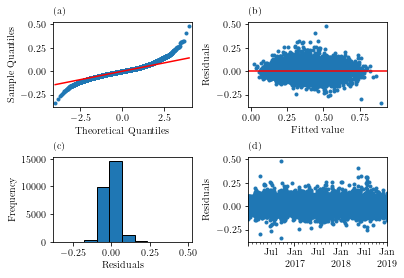

In [27]:
# PM10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True, figsize = (5.5, 3.75))

# QQ-plot of studentized residuals
sm.qqplot(lmod.resid, line='q', ax=ax1, marker=".")
ax1.annotate('(a)', xy=(0, 1.09), xycoords="axes fraction")

# fitted vs residuals
ax2.scatter(lmod.fittedvalues, lmod.resid, marker=".")#, facecolors='none', edgecolors='#1f77b4')
ax2.axhline(0, color='r')
ax2.set_xlabel('Fitted value')
ax2.set_ylabel('Residuals')
ax2.annotate('(b)', xy=(0, 1.09), xycoords="axes fraction")

ax3.hist(lmod.resid, edgecolor='black')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.annotate('(c)', xy=(0, 1.09), xycoords="axes fraction")

lmod.resid.plot(linestyle="", marker='.', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Residuals')
ax4.annotate('(d)', xy=(0, 1.09), xycoords="axes fraction")

# plt.savefig('../plots/Residual_plots_MLR_NO2.pdf')

In [28]:
# dfs for new predictions
y_test = df_test['NO$_x$, Stockholm Torkel Knutssonsgatan'] 
X_test = df_test[stations]

In [29]:
# log transform test data (but keep the target y in original scale)
X_test = np.log(X_test) 

In [30]:
# normalize X and y 
X_test = scaler1.transform(X_test)
X_test = pd.DataFrame(X_test, columns=stations)
X_test.insert(0, 'date', index_test)
X_test.set_index('date', inplace=True)

In [31]:
X_test.insert(0, 'intercept', 1) # insert column of ones in test data

In [32]:
# if temporal signals are to be included
X_test = X_test.merge(df_weather_test.iloc[:,s], on='date')

# if weather parameters are to be included
df_weather_test = df_weather_test.iloc[:, w]
df_weather_norm_test = (df_weather_test-df_weather_test.min())/(df_weather_test.max()-df_weather_test.min())
X_test = X_test.merge(df_weather_norm_test, on='date')

In [33]:
# check if columns in train and test matrices are same
(X_test.columns == X_train.columns).all()

True

In [34]:
# if not normalized
# y_pred_frame = np.exp(lmod.get_prediction(X_test).summary_frame()) # for confidence intervals
# y_pred = np.exp(lmod.predict(X_test))

# if normalized
y_pred = pd.DataFrame(np.exp(scaler2.inverse_transform(lmod.predict(X_test).to_frame())), columns=['NO$_x$, predictions'])
# y_pred = pd.DataFrame(scaler2.inverse_transform(lmod.predict(X_test).to_frame()), columns=['PM$_{10}$, predictions'])
y_pred.insert(0, 'date', index_test)
y_pred.set_index('date', inplace=True)

In [35]:
# metrics
print('RMSE:')
# print(np.sqrt(mean_squared_error(y_pred_frame['mean'], y_test)).round(4))
print(np.sqrt(mean_squared_error(y_pred, y_test)).round(3))

print('\nMAPE:')
# print(mean_absolute_percentage_error(y_pred_frame['mean'], y_test).round(4))
print(mean_absolute_percentage_error(y_pred, y_test).round(3))

RMSE:
9.478

MAPE:
0.227


# Ridge regression

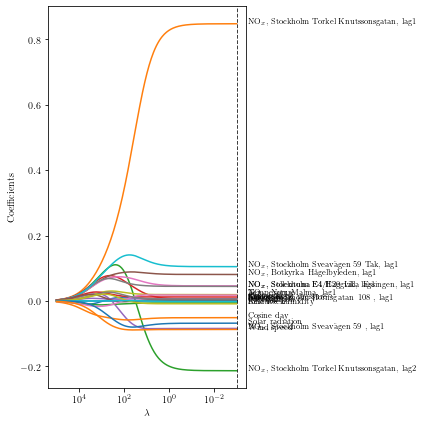

In [36]:
from itertools import chain
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

n_alphas = 250
alphas = np.logspace(-3, 5, n_alphas)
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(list(chain(*ridge.coef_)))
    # coefs.append(ridge.coef_)

# select value of alpha with cross-validation
pars = {'alpha':np.logspace(-3, 5, n_alphas)}
rr = GridSearchCV(linear_model.Ridge(), pars, scoring='r2', cv=10)
rr.fit(X_train, y_train)
bestalpha = rr.best_params_['alpha']


fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
# ridge trace plot
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
for i in range(len(X_train.columns)):
    ax.text(min(alphas)/3.25, coefs[0][i], X_train.columns[i], fontsize=8)
ax.axvline(bestalpha, color='k', linestyle='--', linewidth=1, alpha=.75)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Coefficients')
plt.savefig('../plots/ridge_trace_plot_NO2.pdf')

In [41]:
# new predictions with ridge regression
rrbest = linear_model.Ridge(alpha=bestalpha, fit_intercept=True)
rrbest.fit(X_train, y_train)

print('RMSE:') 
print(np.sqrt(mean_squared_error(np.exp(scaler2.inverse_transform(rrbest.predict(X_test))), y_test)).round(5))
# print(np.sqrt(mean_squared_error(scaler2.inverse_transform(rrbest.predict(X_test)), y_test)).round(5))

print('\nMAPE:')
print(mean_absolute_percentage_error(np.exp(scaler2.inverse_transform(rrbest.predict(X_test))), y_test).round(5))
# print(100*(mean_absolute_percentage_error(scaler2.inverse_transform(rrbest.predict(X_test)), y_test).round(5)))

RMSE:
9.47817

MAPE:
0.22673


# Robust regression

In [42]:
rlmod = sm.RLM(y_train, X_train).fit()
print(rlmod.summary())

                          Robust linear Model Regression Results                         
Dep. Variable:     NO$_x$, Torkel Knutssonsgatan   No. Observations:                26303
Model:                                       RLM   Df Residuals:                    26281
Method:                                     IRLS   Df Model:                           21
Norm:                                     HuberT                                         
Scale Est.:                                  mad                                         
Cov Type:                                     H1                                         
Date:                           Wed, 17 Aug 2022                                         
Time:                                   10:21:50                                         
No. Iterations:                               27                                         
                                                    coef    std err          z      P>|z|      [0.02

In [43]:
# print(np.sqrt(mean_squared_error(np.exp(scaler2.inverse_transform(rlmod.predict(X_test))), y_test)).round(5))
y_pred_robust = pd.DataFrame(np.exp(scaler2.inverse_transform(rlmod.predict(X_test).to_frame())), columns = ['NO$_x$, predictions'])
# y_pred_robust = pd.DataFrame(scaler2.inverse_transform(rlmod.predict(X_test).to_frame()), columns = ['PM$_{10}$, predictions'])
y_pred_robust.insert(0, 'date', index_test)
y_pred_robust.set_index('date', inplace=True)

In [44]:
# metrics
print('RMSE:')
# print(np.sqrt(mean_squared_error(y_pred_frame['mean'], y_test)).round(4))
print(np.sqrt(mean_squared_error(y_pred_robust, y_test)).round(3))

print('\nMAPE:')
# print(mean_absolute_percentage_error(y_pred_frame['mean'], y_test).round(4))
print(mean_absolute_percentage_error(y_pred_robust, y_test).round(3))

RMSE:
9.646

MAPE:
0.226
